# Interactions between ProTα and Histone H1.0 evolution variants

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [4]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [5]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [6]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_k0.14', 'H1-0_VAR_k0.36', 'H1-0_VAR_k0.46', 'H1-0_VAR_k0.30', 'H1-0_VAR_k0.70', 'H1-0_VAR_k0.27', 'H1-0_VAR_k0.75', 'H1-0_VAR_k0.60', 'H1-0_VAR_k0.65', 'H1-0_VAR_k0.55', 'H1-0_VAR_k0.50', 'H1-0_VAR_k0.40', 'H1-0_VAR_k0.07', 'H1-0_VAR_k0.11'])


In [7]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [8]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [9]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [10]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Single chain

In [ ]:
# Loading trajectories
traj = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

### Two chain

#### $K_d$

In [29]:
# Loading precalculated energy data
datas = []
resultsdir = "results/two_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
    data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
    data['Rg'] = float(variant[11:15])
    datas.append(data)
data = pd.concat(datas)
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol],Rg
0,0.630127,-5.144418,0.560969,2.231662,-4.514291,3.61
1,-1.661506,-21.031152,0.517092,1.441419,-22.692659,3.61
2,-1.633053,-1.177342,0.498834,1.725736,-2.810395,3.61
3,-7.488335,-7.651785,0.604542,2.027362,-15.140120,3.61
4,-4.137360,-10.166481,0.597201,2.016862,-14.303840,3.61
...,...,...,...,...,...,...
364995,-5.369769,6.892330,0.547723,3.622540,1.522561,3.96
364996,2.144837,8.681887,0.533991,3.912404,10.826724,3.96
364997,-1.252182,-12.431377,0.555978,3.983490,-13.683558,3.96
364998,-0.550112,-2.225708,0.581061,4.339953,-2.775820,3.96


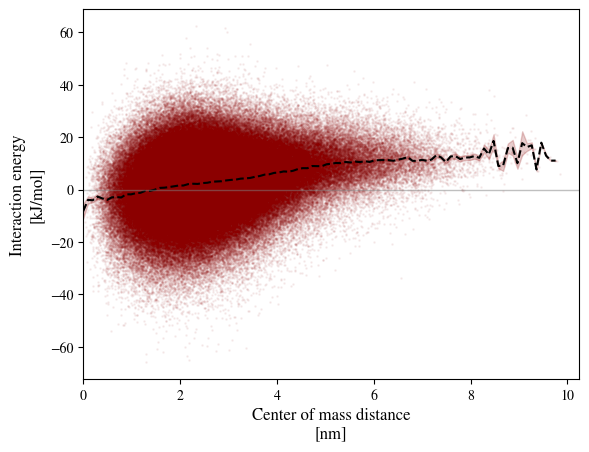

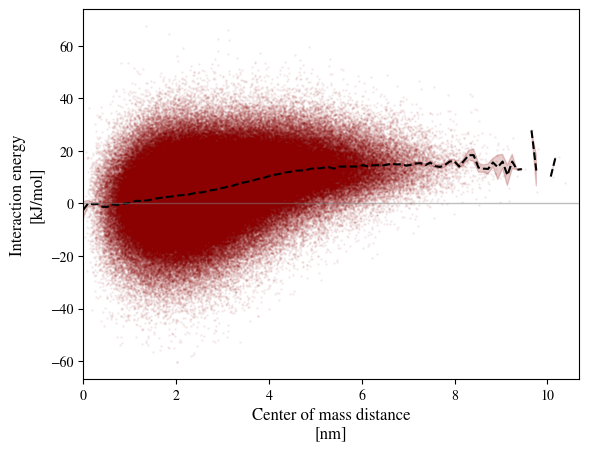

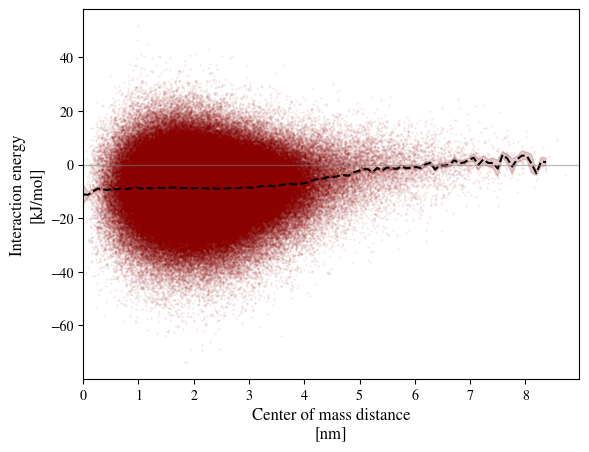

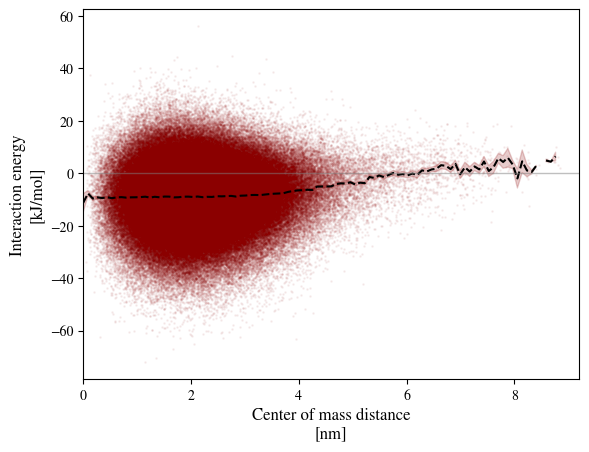

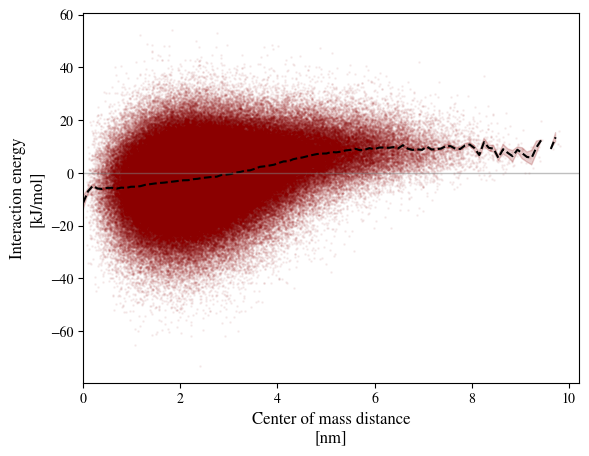

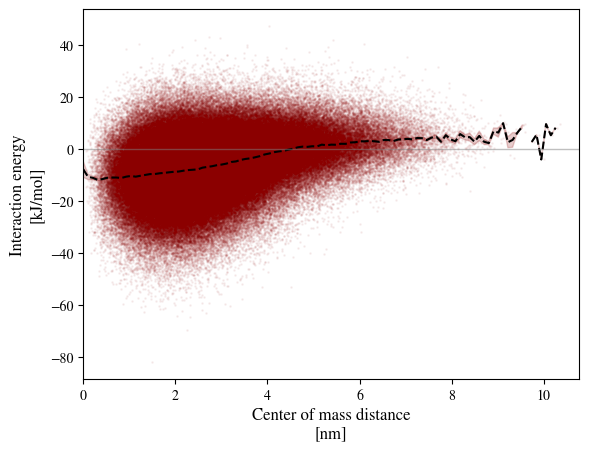

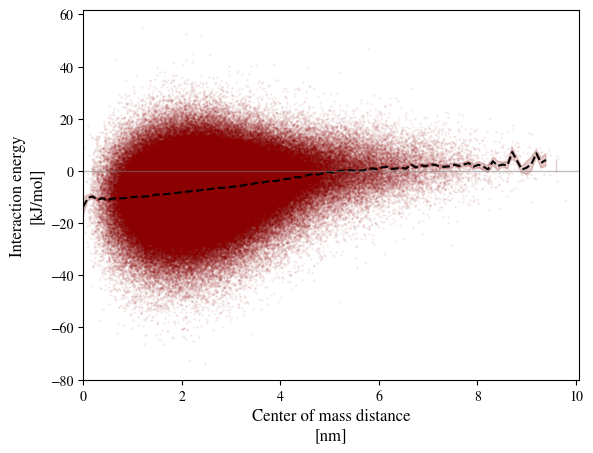

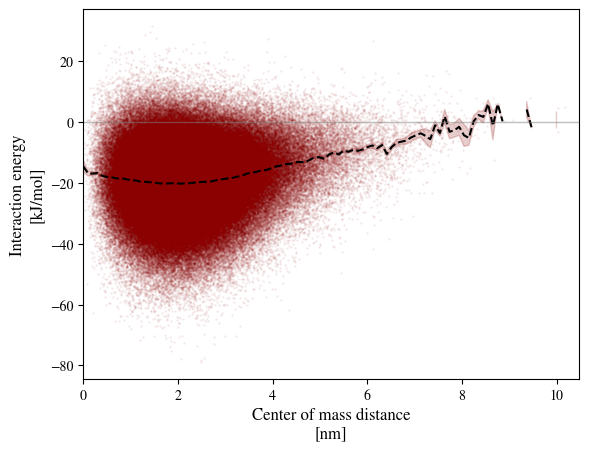

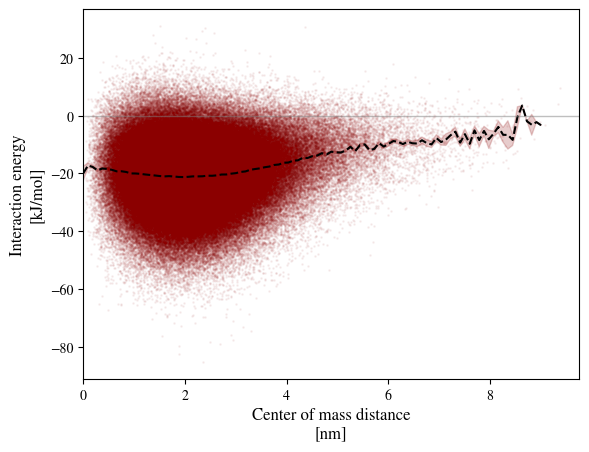

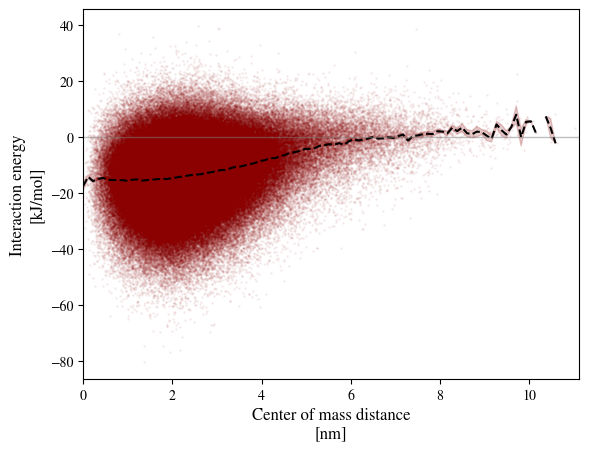

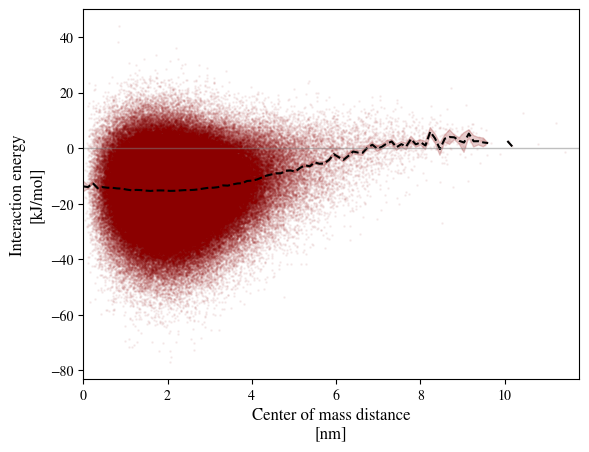

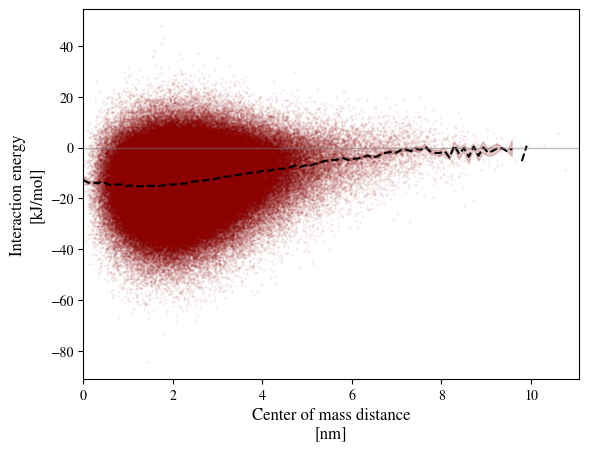

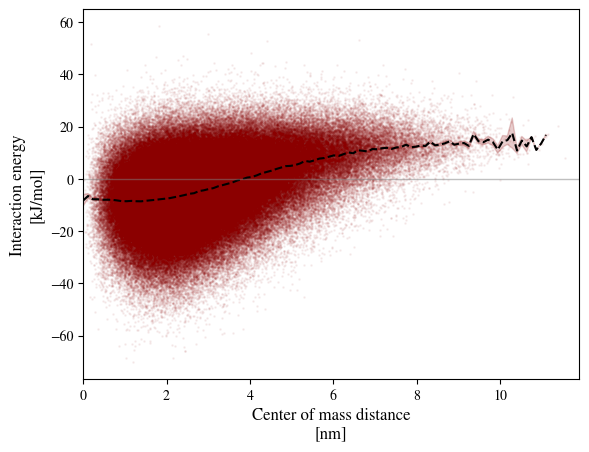

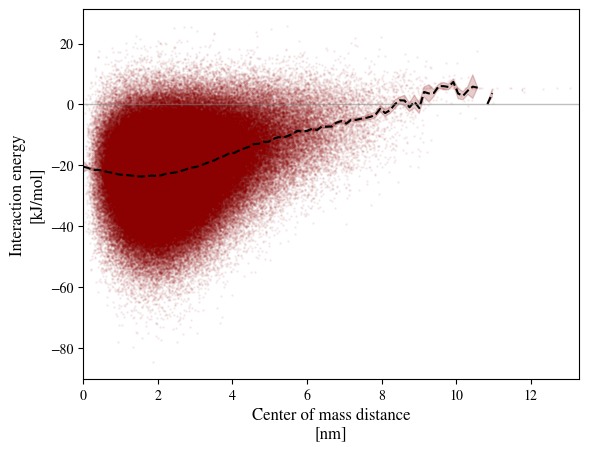

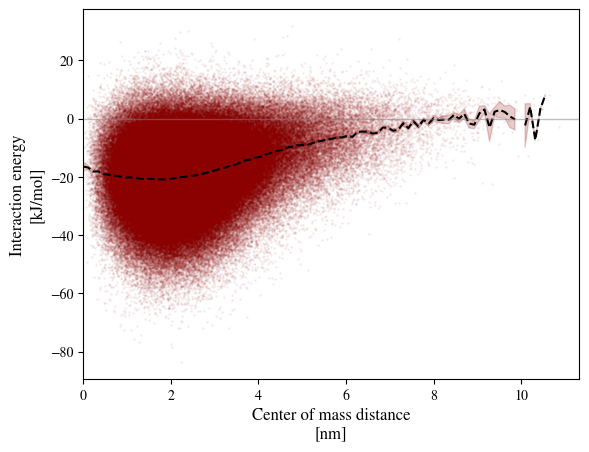

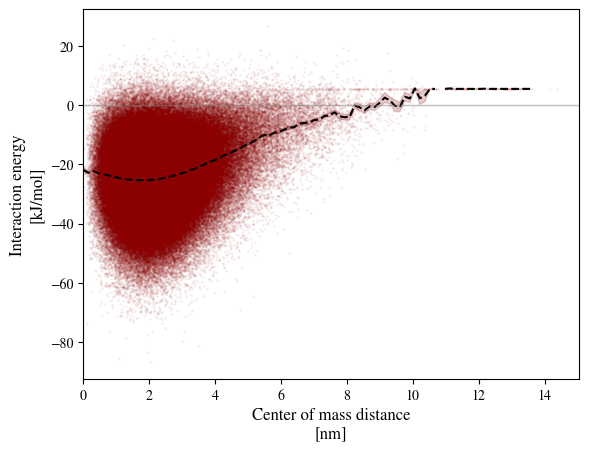

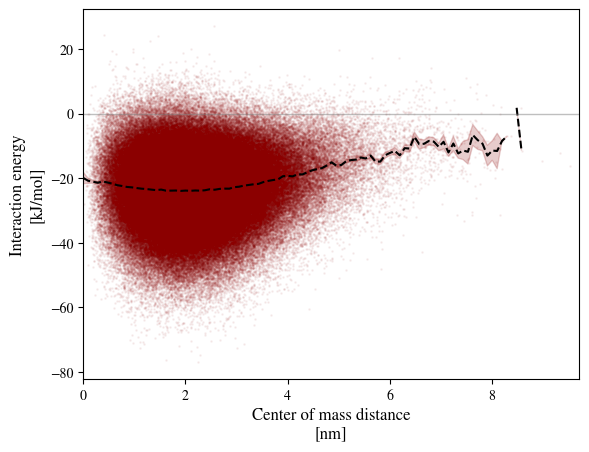

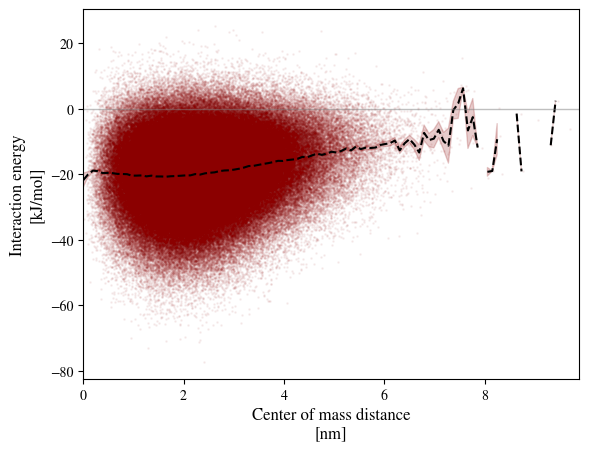

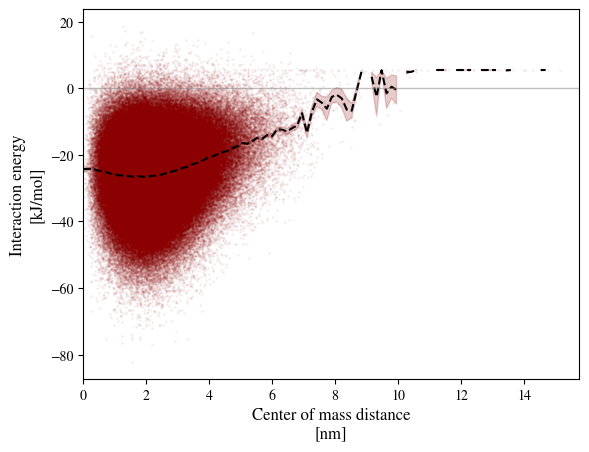

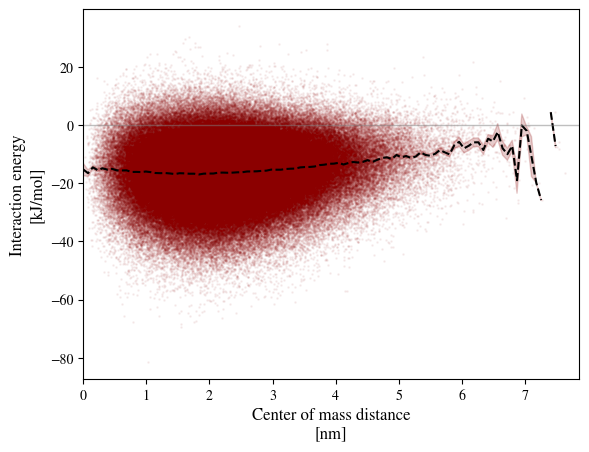

In [31]:
# Calculating Kds and assessing proper sampling
Kds = data.groupby('Rg').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], 298, 100))
cutoff = 4
Kds = pd.DataFrame({
    "Rg": data.groupby('Rg').Rg.max(),
    "Kd": Kds,
    "sampled": data.groupby('Rg').apply(lambda df: any(df['Minimum interresidue distance [nm]'] > cutoff))
})

In [37]:
# Getting kappa values
kappas = []
resultsdir = "results/two_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    top = md.load(dir+'/top.pdb')
    res = simulate_utils.extract_sequences(top.top)
    h10 = res.groupby('chain').aa.apply(''.join)[0]
    kappa = analyse_utils.SequenceParameters(h10).get_kappa()
    kappas.append(kappa)
Kds['kappa'] = kappas

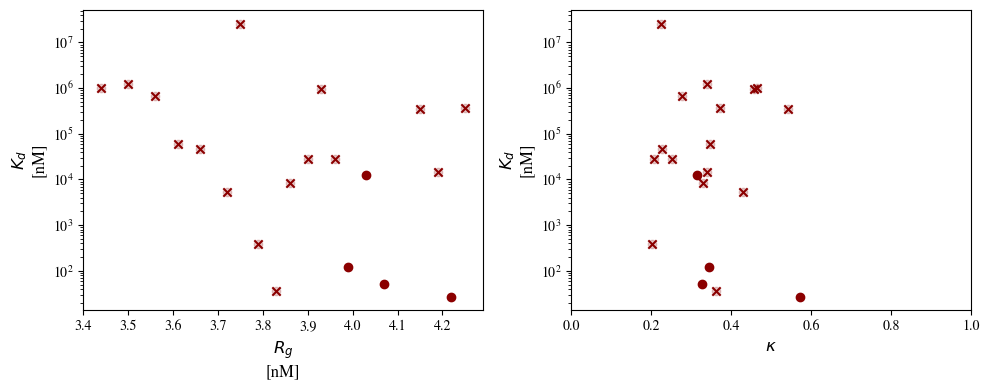

In [39]:
# Plotting results
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.xlabel("$R_g$\n[nM]", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(Kds[~Kds.sampled].Rg, Kds[~Kds.sampled].Kd,  marker='x', color='darkred')
plt.scatter(Kds[~Kds.sampled].Rg, Kds[~Kds.sampled].Kd, color='darkred', alpha=0.2)
plt.scatter(Kds[Kds.sampled].Rg, Kds[Kds.sampled].Kd, color='darkred')

plt.subplot(122)
plt.xlim(0,1)
plt.xlabel("$\kappa$", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Kd,  marker='x', color='darkred')
plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Kd, color='darkred', alpha=0.2)
plt.scatter(Kds[Kds.sampled].kappa, Kds[Kds.sampled].Kd, color='darkred')

plt.tight_layout()


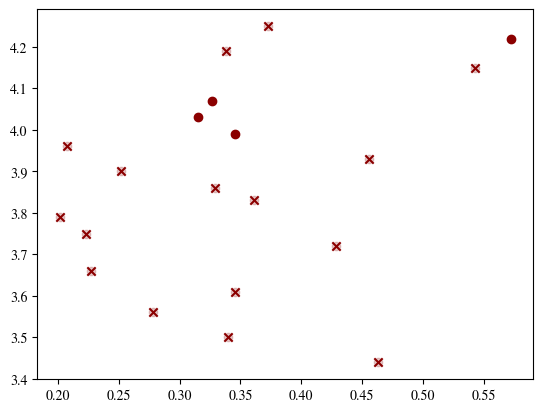

In [41]:
plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Rg,  marker='x', color='darkred')
plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Rg, color='darkred', alpha=0.2)
plt.scatter(Kds[Kds.sampled].kappa, Kds[Kds.sampled].Rg, color='darkred')

/tmp/ipykernel_25071/1339629321.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),label='$R_g$ [nm]')


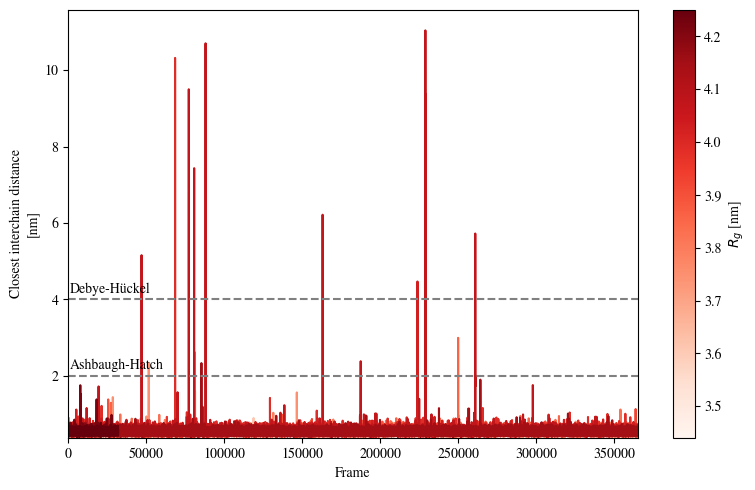

In [14]:
plt.figure(figsize=(8,5))

cmap = plt.cm.Reds
norm = plt.Normalize(vmin=data.Rg.min(), vmax=data.Rg.max())
data.groupby('Rg').apply(lambda df: plt.plot(df['Minimum interresidue distance [nm]'], label=round(df['Rg'].min(),2), color=cmap(norm(df.Rg.max()))))
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),label='$R_g$ [nm]')

plt.xlim(0, max(data.index))
plt.ylim(data['Minimum interresidue distance [nm]'].min())
plt.xlabel('Frame')
plt.ylabel('Closest interchain distance\n[nm]')

plt.hlines([simulate_utils.AH_cutoff, simulate_utils.DH_cutoff],*plt.xlim(), linestyles='--', color='grey')
plt.text(1000, simulate_utils.AH_cutoff+0.1, 'Ashbaugh-Hatch', fontsize=10, va='bottom')
plt.text(1000, simulate_utils.DH_cutoff+0.1, 'Debye-Hückel', fontsize=10, va='bottom')

plt.tight_layout()